## Paquid Data Test

In [153]:
import random

import matplotlib.pyplot as plt
import pandas as pd
import torch
from lifelines import ExponentialFitter
from torch import nn

import jmstate
from jmstate import MultiStateJointModel
from jmstate.typedefs import *
from jmstate.utils import *

In [154]:
paquid = pd.read_csv("data/paquid.csv")

In [155]:
def get_trajectory(id, hier_levels=range(4)):
    s = (
        paquid.loc[paquid["ID"] == id]
        .groupby("HIER")["age"]
        .min()
        .reindex(hier_levels)
        .dropna()
    )
    if len(s) <= 1:
        return [(float(a), int(k)) for k, a in s.items()]
    keep = s >= s.cummax()
    s = s[keep]
    return [(float(a), int(k)) for k, a in s.items()]


def get_last_visit_age(id):
    return paquid[paquid["ID"] == id]["age"].max()


def get_t(id):
    return torch.tensor(paquid[paquid["ID"] == id]["age"].values)


def get_X(id):
    return torch.tensor(
        paquid.loc[paquid["ID"] == id, ["CEP", "male"]].iloc[0].to_numpy()
    )


def get_Y(id):
    return torch.tensor(paquid[paquid["ID"] == id]["MMSE"].values)

In [156]:
def prepare_all(ids):
    trajectories0 = [get_trajectory(i) for i in ids]
    c0 = torch.tensor([get_last_visit_age(i) for i in ids]).view(-1, 1)
    t0 = torch.nn.utils.rnn.pad_sequence([get_t(i) for i in ids], batch_first=True, padding_value=torch.nan)
    y0 = torch.nn.utils.rnn.pad_sequence([get_Y(i) for i in ids], batch_first=True, padding_value=torch.nan)[..., None]
    x = torch.cat([get_X(i).view(1, -1) for i in ids], dim=0)
    x = torch.cat([x, torch.ones(*x.shape[:-1], 1)], dim=-1)

    t_min, t_max = torch.nanquantile(t0, 0).item(), torch.nanquantile(t0, 1).item()
    y_min, y_max = torch.nanquantile(y0, 0).item(), torch.nanquantile(y0, 1).item()

    def normalize_t(t):
        return (2.0 * t - (t_max + t_min)) / (t_max - t_min)
    def normalize_y(y):
        return (2.0 * y - (y_max + y_min)) / (y_max - y_min)

    y = normalize_y(y0)
    trajectories = [[(normalize_t(m), s) for (m, s) in traj] for traj in trajectories0]
    t = normalize_t(t0)
    c = normalize_t(c0)

    return x, t, y, trajectories, c

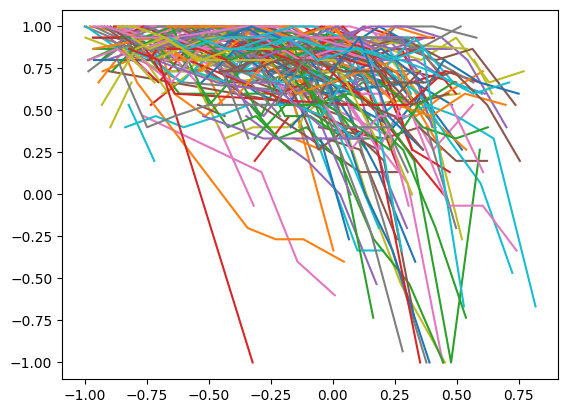

In [157]:
ids = random.sample(range(1, 501), 300)

x, t, y, trajectories, c = prepare_all(ids)

plt.plot(t.T, y[:, :, 0].T)
plt.show()

In [158]:
buckets = build_buckets(trajectories)

In [159]:
surv_params = {}
for key, value in buckets.items():
    t0, t1 = value.t0, value.t1
    exp_fit = ExponentialFitter().fit(t1 - t0)
    surv_params[key] = exp_fit.lambda_

In [160]:
def reg(t, psi):
    a, b, c = psi.chunk(3, dim=-1)
    return (a * torch.tanh(2 * (t - c) / (a * b)) + (1-a)).unsqueeze(-1)

def f(gamma, x, b):
    psi = gamma + b
    psi[..., 0] = torch.sigmoid(psi[..., 0])
    psi[..., 1] = -psi[..., 1].exp()
    return psi

surv = {key: HazardFns(jmstate.functions.Exponential(1), reg) for key in buckets}

init_alphas = {key: torch.zeros(1) for key in buckets}
init_betas = {key: torch.zeros(3) for key in buckets}

init_params = ModelParams(
    torch.zeros(3),
    repr_from_cov(torch.eye(3), method="full"),
    repr_from_cov(torch.eye(1), method="ball"),
    init_alphas,
    init_betas,
)

model_design = ModelDesign(
    f,
    reg,
    surv,
)

In [161]:
data = ModelData(x, t, y, trajectories, c)

Running joint model: 100%|██████████| 200/200 [00:06<00:00, 29.71it/s]


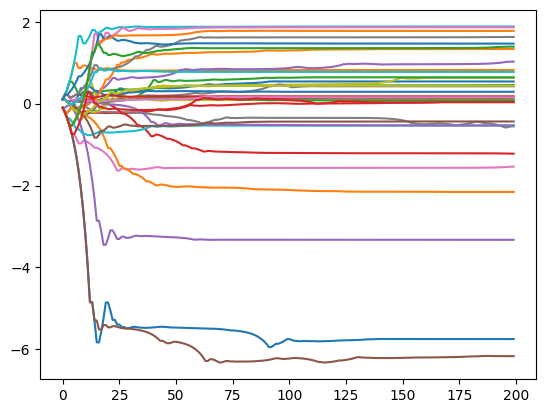

In [162]:
model = MultiStateJointModel(model_design, init_params)
metrics = model.do(
    data,
    job_factories=[
        jmstate.jobs.RandomFit(torch.optim.Rprop, lr=0.1),
        jmstate.jobs.LogParamsHistory(),
    ],
    max_iterations=200,
    n_steps=10,
)

plt.plot(torch.cat([p.as_flat_tensor[None] for p in metrics], dim=0))
plt.show()

In [163]:
print(model.params_)
model.params_.get_cov("Q")

ModelParams(gamma=tensor([0.5401, 0.8227, 0.4521]), Q_repr=MatRepr(flat=tensor([ 0.0468,  1.0260,  0.1050, -1.5390, -0.5556,  0.6282]), dim=3, method='full'), R_repr=MatRepr(flat=tensor([1.8834]), dim=1, method='ball'), alphas={(0, 3): tensor([-5.7496]), (0, 2): tensor([-2.1567]), (0, 1): tensor([0.6431]), (1, 2): tensor([-1.2222]), (2, 3): tensor([-3.3261]), (1, 3): tensor([-6.1668])}, betas={(0, 3): tensor([1.8640, 0.4222, 0.0892]), (0, 2): tensor([-0.5357,  0.2892,  1.3348]), (0, 1): tensor([ 0.0805,  0.1783, -0.5332]), (1, 2): tensor([-0.4361,  0.1540,  1.6268]), (2, 3): tensor([0.4362, 0.7748, 1.4651]), (1, 3): tensor([1.7761, 1.3897, 0.0335])})


tensor([[ 1.9605, -0.6543,  0.2786],
        [-0.6543,  0.8819,  0.1424],
        [ 0.2786,  0.1424,  0.2847]])

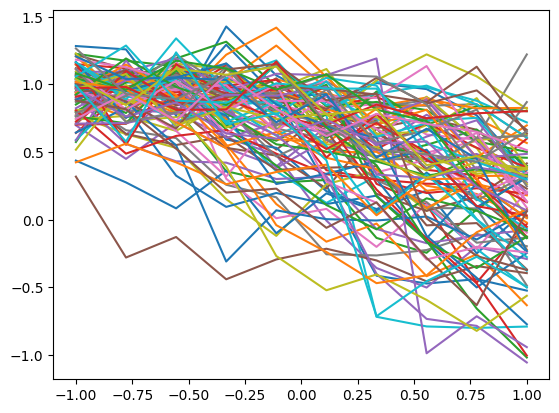

In [164]:
n_test = 100
t_test = torch.linspace(-1, 1, 10)

Q_dist = torch.distributions.MultivariateNormal(
    torch.zeros(3), model.params_.get_cov("Q")
)
R_dist = torch.distributions.MultivariateNormal(
    torch.zeros(1), model.params_.get_cov("R")
)

x_test = x[:n_test]
b_test = Q_dist.sample((n_test,))
psi_test = model_design.individual_effects_fn(model.params_.gamma, x_test, b_test)
trajectories_init_test = [[trajectories[i][0]] for i in range(n_test)]
y_test = model_design.regression_fn(t_test, psi_test)
y_test += R_dist.sample(y_test.shape[:-1])
plt.plot(t_test, y_test[:, :, 0].T)
plt.show()

In [165]:
sample_data_test = SampleData(x_test, trajectories_init_test, psi_test)
trajectories_test = model.sample_trajectories(
    sample_data_test, torch.full((len(trajectories_init_test), 1), 1.0)
)